In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Load the Titanic dataset
from sklearn.datasets import fetch_openml
print("Loading Titanic dataset...")
titanic = fetch_openml(name='titanic', version=1, as_frame=True)
df = titanic.data
df['survived'] = titanic.target

Loading Titanic dataset...


In [ ]:
def preprocess_data(df):
    """
    Perform data preprocessing steps including handling missing values,
    feature engineering, and encoding categorical variables.

    Args:
        df (pandas.DataFrame): Raw Titanic dataset

    Returns:
        pandas.DataFrame: Preprocessed dataset
    """
    # Create a copy of the dataframe
    df_processed = df.copy()

    # Handle missing values
    # Fill missing age values with median age
    df_processed['age'].fillna(df_processed['age'].median(), inplace=True)

    # Fill missing embarked values with mode
    df_processed['embarked'].fillna(df_processed['embarked'].mode()[0], inplace=True)

    # Fill missing cabin values with 'Unknown'
    df_processed['cabin'].fillna('Unknown', inplace=True)

    # Feature Engineering
    # Extract title from name
    df_processed['title'] = df_processed['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    # Group rare titles
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
    df_processed['title'] = df_processed['title'].replace(rare_titles, 'Rare')

    # Create family size feature
    df_processed['family_size'] = df_processed['sibsp'] + df_processed['parch'] + 1

    # Create is_alone feature
    df_processed['is_alone'] = (df_processed['family_size'] == 1).astype(int)

    # Extract deck from cabin
    df_processed['deck'] = df_processed['cabin'].str[0]

    # Encode categorical variables
    categorical_columns = ['sex', 'embarked', 'title', 'deck']
    le = LabelEncoder()
    for column in categorical_columns:
        df_processed[column] = le.fit_transform(df_processed[column])

    # Select features for model
    features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
               'embarked', 'title', 'family_size', 'is_alone', 'deck']

    return df_processed[features], df_processed['survived']

In [ ]:
def perform_eda(df):
    """
    Perform exploratory data analysis and create visualizations.

    Args:
        df (pandas.DataFrame): Titanic dataset
    """
    print("\nExploratory Data Analysis:")
    print("\nBasic Information:")
    print(df.info())

    print("\nDescriptive Statistics:")
    print(df.describe())

    # Survival rate by class
    plt.figure(figsize=(10, 6))
    sns.barplot(x='pclass', y='survived', data=df)
    plt.title('Survival Rate by Passenger Class')
    plt.show()

    # Age distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='age', bins=30)
    plt.title('Age Distribution')
    plt.show()

    # Survival rate by sex
    plt.figure(figsize=(10, 6))
    sns.barplot(x='sex', y='survived', data=df)
    plt.title('Survival Rate by Sex')
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(12, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [ ]:
def build_model(X, y):
    """
    Build and train a Random Forest model with hyperparameter tuning.

    Args:
        X (pandas.DataFrame): Feature matrix
        y (pandas.Series): Target variable

    Returns:
        tuple: Best model, feature importances, and best parameters
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(random_state=42)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                             cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_scaled, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Make predictions and print metrics
    y_pred = best_model.predict(X_test_scaled)

    print("\nModel Performance:")
    print("\nBest Parameters:", grid_search.best_params_)
    print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.show()

    return best_model, feature_importance, grid_search.best_params_


Starting Titanic Dataset Analysis...

Preprocessing data...

Exploratory Data Analysis:

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   int64   
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   int64   
 5   parch      1309 non-null   int64   
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
 13  survived   1309 non-null   category
dtypes: category(3), float64(3), int64(3), object(5)
memory usage: 116.8+ KB
None

Descriptive Statistics:
            pclass    

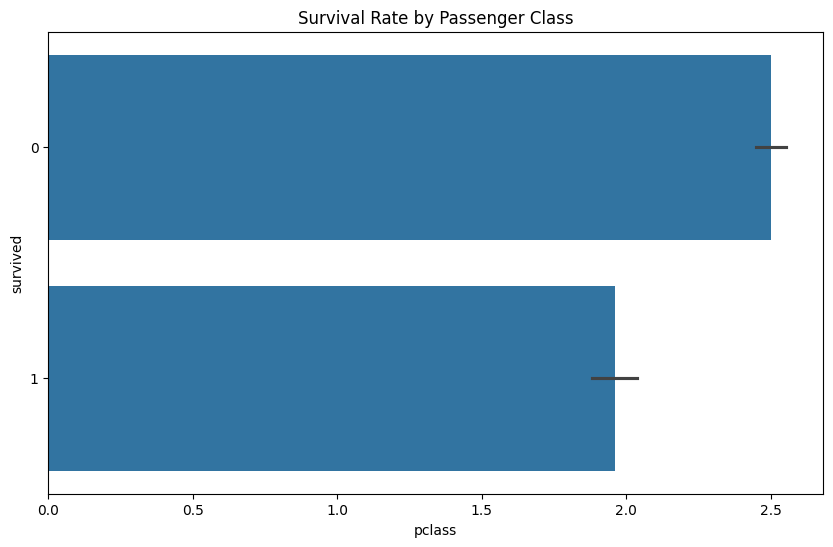

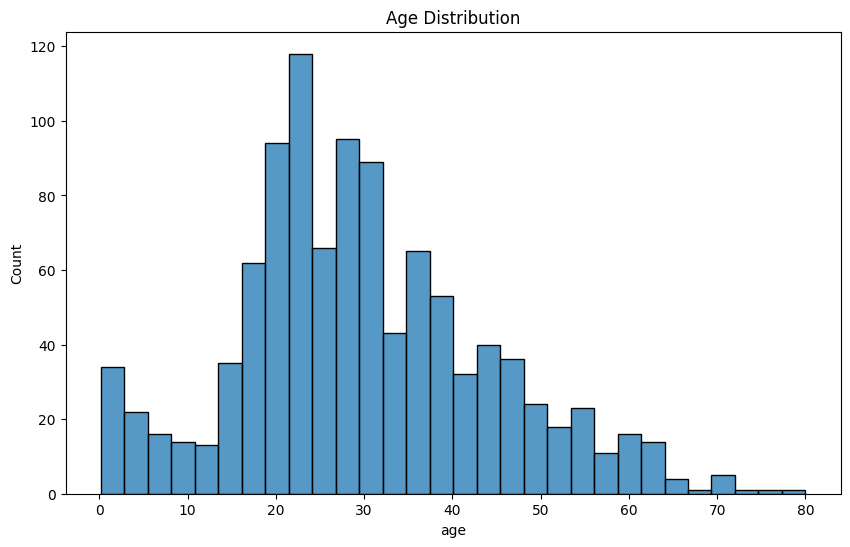

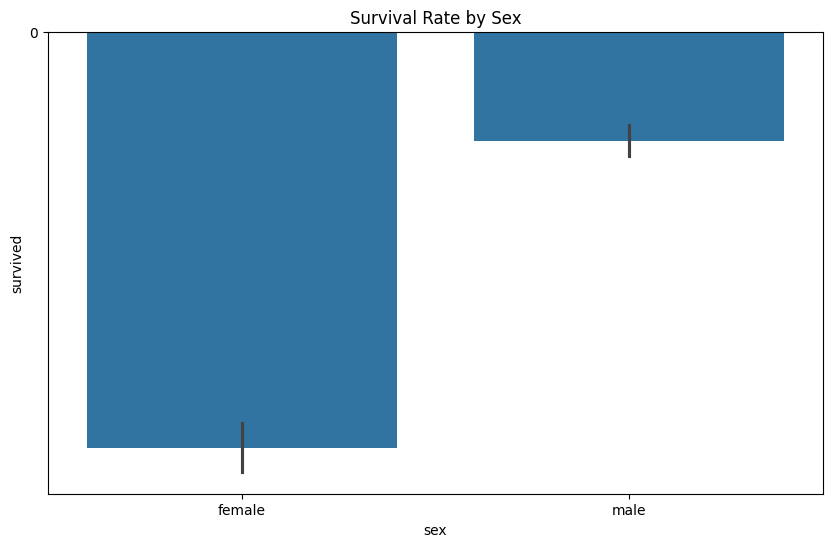

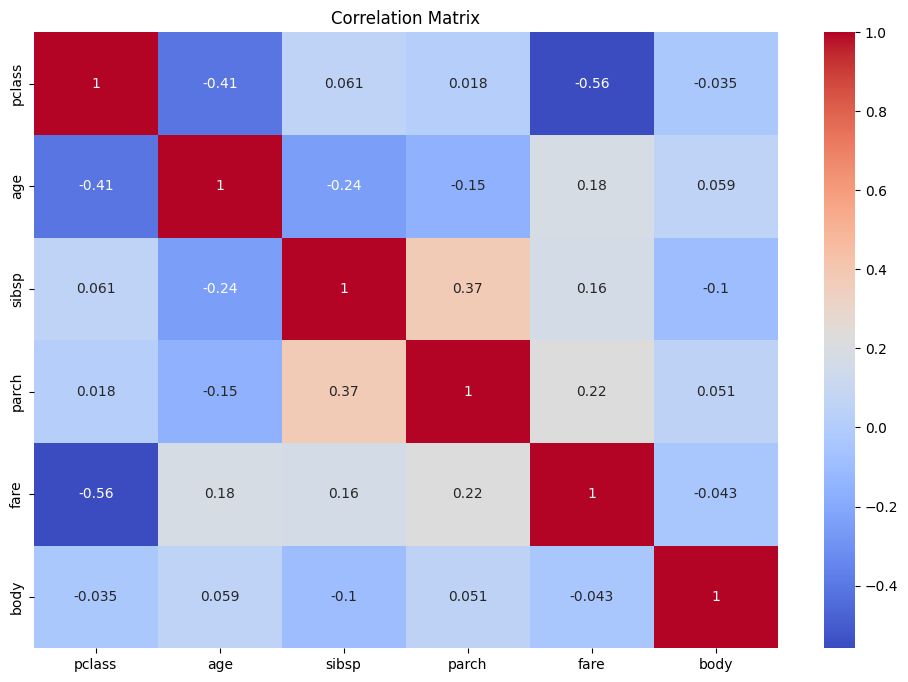


Building and evaluating model...

Model Performance:

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Accuracy Score: 0.7709923664122137

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       144
           1       0.84      0.61      0.71       118

    accuracy                           0.77       262
   macro avg       0.79      0.76      0.76       262
weighted avg       0.78      0.77      0.76       262



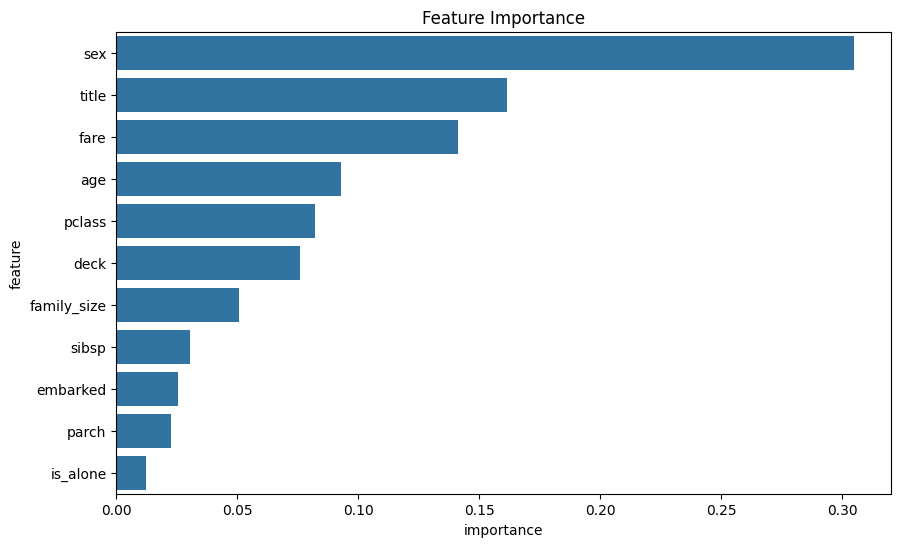


Analysis complete!


In [ ]:
def main():
    """
    Main function to run the entire analysis pipeline.
    """
    print("Starting Titanic Dataset Analysis...")

    # Preprocess data
    print("\nPreprocessing data...")
    X, y = preprocess_data(df)

    # Perform EDA
    perform_eda(df)

    # Build and evaluate model
    print("\nBuilding and evaluating model...")
    best_model, feature_importance, best_params = build_model(X, y)

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()